
# <i class="fa-brands fa-python"></i> Neuroimaging

Neuroimaging libraries depend on the specific modality you are dealing with. While there are *many* packages out there, this section will introduce the most widely used ones, which you will also need for the practical part of the workshop tomorrow.

## fMRI

### NiBabel

Core I/O support for neuroimaging file formats (NIfTI, Analyze, MGH, MINC, etc.). Provides utilities to load, save, and manipulate image headers and data arrays.

- PyPI: https://pypi.org/project/nibabel/
- Docs: https://nipy.org/nibabel/

### Nilearn

High-level statistical learning and visualization on neuroimaging data. Built on scikit-learn, it offers functions for decoding, predictive modeling, functional connectivity, and easy plotting of brain maps.

- PyPI: https://pypi.org/project/nilearn/
- Docs: https://nilearn.github.io/


### Usage Example

Let's look at some real data to get a better sense of why arrays are a useful thing to use. We use the `nilearn` package to load fMRI data of a single subject from the ADHD dataset and then convert the data into a numpy array with the `nibabel` package:

In [1]:
import nibabel as nib
from nilearn import datasets

haxby_dataset = datasets.fetch_adhd(n_subjects=1); # Download data
fmri_img = nib.load(haxby_dataset.func[0])         # Load the fMRI image
fmri_data = fmri_img.get_fdata()                   # Get data as a 4D array

print(f"Shape of the fMRI data: {fmri_data.shape}")

[get_dataset_dir] Dataset found in /home/mibur/nilearn_data/adhd
Shape of the fMRI data: (61, 73, 61, 176)


You can see that the data has shape `(61, 73, 61, 176)`, meaning that it has four dimensions. fMRI data is similar to a picture which is composed of individual pixels, with the addition that the brain is a three-dimensional object and is thus separated in little cubes called *voxels*. As such three-dimensional scans are aquired in slices, the first two dimensions are the in-plane dimensions of the scan ($61 * 73$ voxels), the third dimension are the $61$ slices, and the third dimension is the time, telling us that $176$ scans of the brain were obtained over time.

We can then plot the mean of this brain scan e.g. manually with matplotlib:

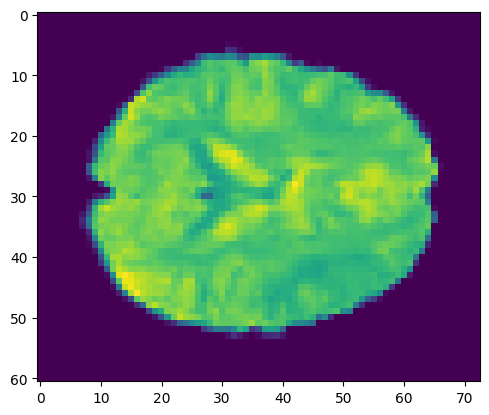

In [2]:
import numpy as np
from matplotlib import pyplot as plt

mean_image = np.mean(fmri_data[:,:,30,:], axis=-1)
plt.imshow(mean_image);

Or with one of the nilearn plotting functions:

/tmp/ipykernel_209179/434131761.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_image = mean_img(fmri_img)


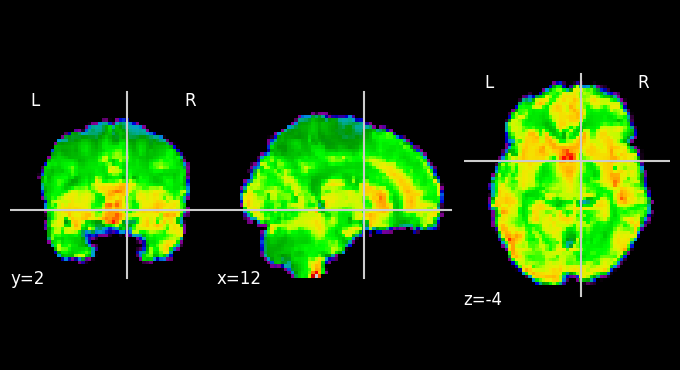

In [3]:
from nilearn import plotting
from nilearn.image import mean_img

mean_image = mean_img(fmri_img)
plotting.plot_epi(mean_image);

Connectivity based analyses can be performed the following way:

In [4]:
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker

# Get data
data = datasets.fetch_development_fmri(n_subjects=1, verbose=0)
print(f"First subject functional nifti images (4D) are at: {data.func[0]}")

# Get atlas
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas["maps"]
labels = atlas["labels"]

# Extract time series
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize="zscore_sample", standardize_confounds="zscore_sample")
time_series = masker.fit_transform(data.func[0], confounds=data.confounds)
print("Parcellated fMRI time series shape:", time_series.shape)

# Estimate functional connectivity with pearson correlation
fc = np.corrcoef(time_series.T)
print("Connectivity matrix shape:", fc.shape)

[get_dataset_dir] Dataset found in /home/mibur/nilearn_data/development_fmri
First subject functional nifti images (4D) are at: /home/mibur/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[get_dataset_dir] Dataset found in /home/mibur/nilearn_data/msdl_atlas
Parcellated fMRI time series shape: (168, 39)
Connectivity matrix shape: (39, 39)


Once we have the symmetric connectivity matrix, we can use it for visualization purposes:

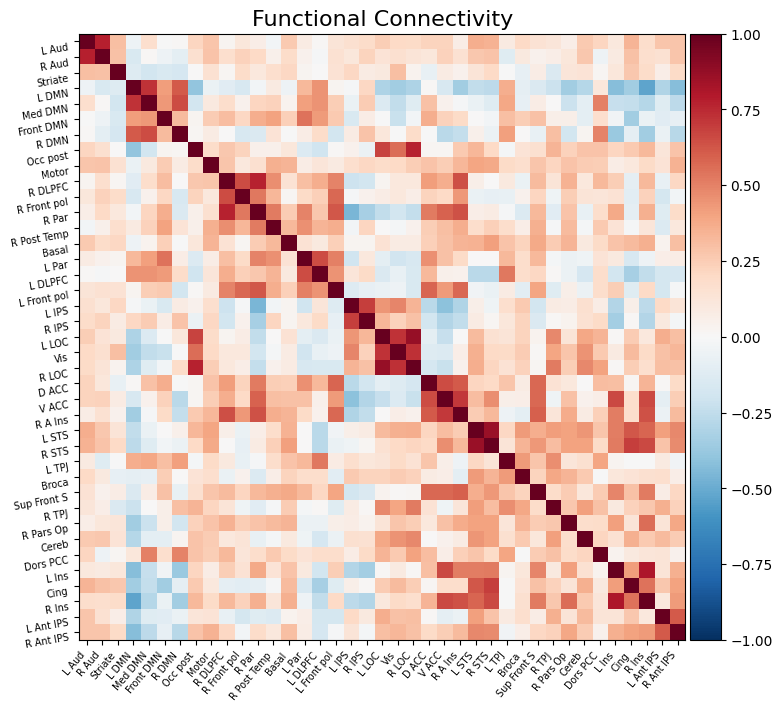

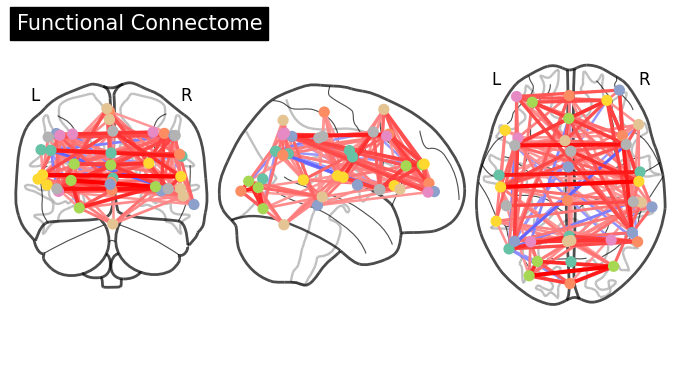

In [5]:
# Plot connectivity matrix
plotting.plot_matrix(fc, labels=labels, figure=(9, 7), vmax=1, vmin=-1, title="Functional Connectivity",);

# Plot connectome
coords = atlas.region_coords
plotting.plot_connectome(fc, coords, title="Functional Connectome", edge_threshold="80%");


## EEG

### MNE-Python

The go-to package for EEG/MEG data: supports raw‐data I/O (EDF, BDF, BrainVision, etc.), preprocessing (filtering, ICA, SSP), epoching, time-frequency analysis, source localization (via FreeSurfer), connectivity, and powerful visualization routines.

- Docs: https://mne.tools/stable/index.html
- PyPI: https://pypi.org/project/mne/


### Usage Example

The following example loads some MNE example data and plots the condition-average ERP waveforms as well as topographies:

Projections have already been applied. Setting proj attribute to True.


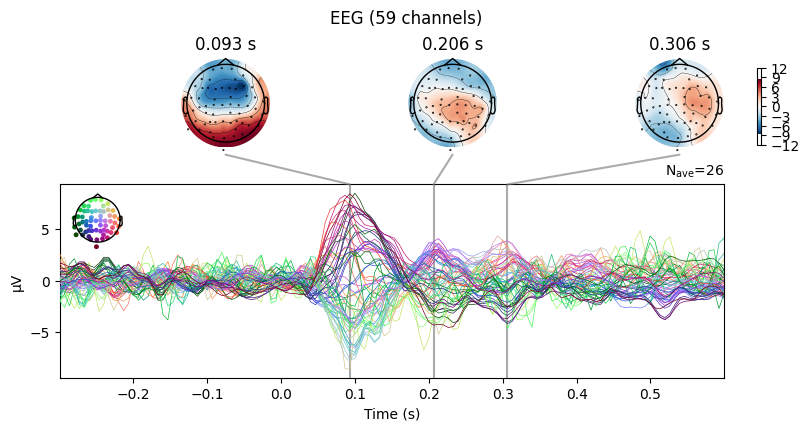

In [6]:
import mne

# Load data
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=True, verbose=False)

# Get events
events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

# Crop the data from 450 to 90 seconds
raw.crop(tmax=90)

# Pick channels
raw.pick(['eeg', 'eog'])

# Filtering
raw.filter(l_freq=0.1, h_freq=None, verbose=False)

# Code events
np.unique(events[:, -1])
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

# Epoching
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.6, preload=True, verbose=False)

# Drop bad epochs
epochs.drop_bad(reject=dict(eeg=100e-6, eog=200e-6), verbose=False)  # 100 µV, 200 µV

# Plot ERP waveforms and topographies
l_aud = epochs["auditory/left"].average()
l_aud.plot_joint();